# Music Box Churn Prediction and Recommendation using Spark

# Data preprocessing

## 1. Get user id list and count

* Must add **export LANG=C** to avoid _error: illegal byte sequence_.
  * See [Getting “sed error - illegal byte sequence” (in bash)
](https://stackoverflow.com/questions/11287564/getting-sed-error-illegal-byte-sequence-in-bash)

In [1]:
import os

cmd = r"""
export LC_CTYPE=C 
export LANG=C
cat /Users/ytshen/Desktop/Machine_Learning/Music_Box/data/all_play_log | cut -f1 -d$'\t' | sort | uniq -c | sed -e 's/^ *//g;s/ *$//g' > data/uid_count.csv
"""
print(cmd)

os.system(cmd)


export LC_CTYPE=C 
export LANG=C
cat /Users/ytshen/Desktop/Machine_Learning/Music_Box/data/all_play_log | cut -f1 -d$'\t' | sort | uniq -c | sed -e 's/^ *//g;s/ *$//g' > uid_count.csv



0

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Use `pd.read_csv(filename, sep=' ',header=None)` to specify the separator as a single space.

Use `pd.read_csv(filename, sep='\s+',header=None)` to specify the separator as spaces or tab.

In [3]:
df_uid = pd.read_csv('uid_count.csv', sep='\s+', names=['count', 'uid'])

In [4]:
df_uid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594534 entries, 0 to 594533
Data columns (total 2 columns):
count    594534 non-null int64
uid      594533 non-null float64
dtypes: float64(1), int64(1)
memory usage: 9.1 MB


In [5]:
df_uid.head()

,count,uid
0,2,NaN
1,1161804,0.0
2,2,100002491.0
3,56,100052111.0
4,9,100071797.0


In [6]:
df_uid.describe()

,count,uid
count,5.945340e+05,5.945330e+05
mean,2.451517e+02,1.673632e+08
std,1.520558e+04,1.047090e+07
min,1.000000e+00,0.000000e+00
25%,9.000000e+00,1.680265e+08
50%,4.000000e+01,1.684785e+08
75%,1.730000e+02,1.687686e+08
max,7.467056e+06,1.692623e+08


## 2. Remove bots and outliers

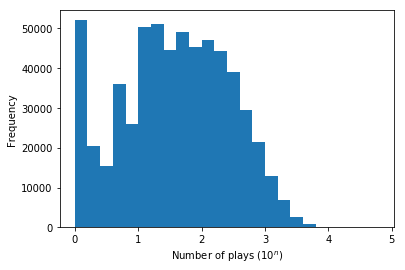

In [7]:
ax = np.log10(df_uid['count']).plot.hist(bins=np.arange(0, 5, 0.2))
ax.set_xlabel('Number of plays ($10^n$)')
plt.show()

Find the number of plays for 99.9% of the users and set the rest to be outliers.

In [8]:
# Select the number of plays of 99.9% user
count_threshold = round(np.percentile(df_uid['count'], 99.9))
print('99.9%% of the users have number of plays less then %d' % count_threshold)

99.9% of the users have number of plays less then 5174


In [9]:
# Select the outliers
outliers = df_uid[df_uid['count'] > count_threshold]

before_droping_outliers = len(df_uid)

# drop outliers
df_uid_remove_outliers = df_uid.drop(outliers.index).dropna()
after_droping_outliers = len(df_uid_remove_outliers)

print('Before droping outliers, there are %d rows and after droping outliers, there are %d rows.' % (before_droping_outliers, after_droping_outliers))
print('Each row is a user id (uid).')

Before droping outliers, there are 594534 rows and after droping outliers, there are 593938 rows.
Each row is a user id (uid).


## 3. Apply downsampling on `uid` level

In [10]:
np.random.seed = 1
downsample_ratio = 0.1

In [11]:
id_list_bot_removed = np.array(df_uid['uid'][df_uid['count'] < count_threshold].dropna())
id_subset = set(id_list_bot_removed[np.random.random(id_list_bot_removed.shape) < downsample_ratio])
print('Number of user after downsampling: ', len(id_subset))

Number of user after downsampling:  59392


#### Convert datetime format

In [12]:
import datetime

def convert_date(s):
    s = str(s).strip()
    try:
        year = int(s[:4])
        month = int(s[4:6])
        day = int(s[6:8])
        return datetime.date(year, month, day)
    except:
        return None

#### Downsample

In [13]:
import csv

def downsample_csv(input_file, output_file, input_fields, output_fields):
    with open(input_file, 'r', encoding='latin-1') as fin, open(output_file, 'w') as fout:
        csv_in = csv.DictReader(fin, delimiter='\t', fieldnames=input_fields, quoting=csv.QUOTE_NONE)
        csv_out = csv.writer(fout, delimiter=',')

        # write header
        csv_out.writerow(output_fields)

        for row in csv_in:
            try:
                int(row['uid'])
            except:
                continue
            if int(row['uid']) in id_subset:
                row['date'] = convert_date(row['date'])
                if row['date'] != None:
                    csv_out.writerow([str(row[key]).strip() for key in output_fields])

Downsample `all_play_log`

In [14]:
input_file = '/Users/ytshen/Desktop/Machine_Learning/Music_Box/data/all_play_log'
output_file = '/Users/ytshen/Desktop/Machine_Learning/Music_Box/data/play_ds.csv'

input_fields = ['uid','device','song_id','song_type','song_name','singer','play_time','song_length','paid_flag','date']
output_fields = ['uid', 'device', 'song_id', 'date', 'play_time', 'song_length']

downsample_csv(input_file, output_file, input_fields, output_fields)

Downsample `all_down_log`

In [15]:
input_file = '/Users/ytshen/Desktop/Machine_Learning/Music_Box/data/all_down_log'
output_file = '/Users/ytshen/Desktop/Machine_Learning/Music_Box/data/down_ds.csv'

input_fields = ['uid', 'device', 'song_id', 'song_name', 'singer', 'paid_flag', 'date']
output_fields = ['uid', 'device', 'song_id', 'date']

downsample_csv(input_file, output_file, input_fields, output_fields)

Downsample `all_search_log`

In [16]:
input_file = '/Users/ytshen/Desktop/Machine_Learning/Music_Box/data/all_search_log'
output_file = '/Users/ytshen/Desktop/Machine_Learning/Music_Box/data/search_ds.csv'

input_fields = ['uid', 'device', 'time_stamp', 'search_query', 'date']
output_fields = ['uid', 'device', 'date']

downsample_csv(input_file, output_file, input_fields, output_fields)

## 4. Create event table

In [17]:
def create_event_table(file_play, file_down, file_search, file_output, fields_play, fields_down, fields_search, fields_output):
    with open(file_play, 'r') as fplay, open(file_down, 'r') as fdown, \
         open(file_search, 'r') as fsearch, open(file_output, 'w') as fout:
        csv_play = csv.DictReader(fplay, delimiter=',', fieldnames=fields_play)
        csv_down = csv.DictReader(fdown, delimiter=',', fieldnames=fields_down)
        csv_search = csv.DictReader(fsearch, delimiter=',', fieldnames=fields_search)
        
        csv_out = csv.writer(fout, delimiter=',')
        # write header
        csv_out.writerow(fields_output)
        
        for row in csv_play:
            row['event'] = 'P'
            try:
                int(row['uid'])
            except:
                continue
            csv_out.writerow([row[key] for key in fields_output])
        for row in csv_down:
            row['event'] = 'D'
            try:
                int(row['uid'])
            except:
                continue
            csv_out.writerow([row[key] for key in fields_output])
        for row in csv_search:
            row['event'] = 'S'
            try:
                int(row['uid'])
            except:
                continue
            csv_out.writerow([row.get(key, '') for key in fields_output])

In [18]:
file_play = '/Users/ytshen/Desktop/Machine_Learning/Music_Box/data/play_ds.csv'
file_down = '/Users/ytshen/Desktop/Machine_Learning/Music_Box/data/down_ds.csv'
file_search = '/Users/ytshen/Desktop/Machine_Learning/Music_Box/data/search_ds.csv'

fields_play = ['uid', 'device', 'song_id', 'date', 'play_time', 'song_length']
fields_down = ['uid', 'device', 'song_id', 'date']
fields_search = ['uid', 'device', 'date']

file_output = '/Users/ytshen/Desktop/Machine_Learning/Music_Box/data/event_ds.csv'
fields_output = ['uid', 'event', 'song_id', 'date']

create_event_table(file_play, file_down, file_search, file_output, fields_play, fields_down, fields_search, fields_output)